# 2D Advection-Diffusion equation

in this notebook we provide a simple example of the DeepMoD algorithm and apply it on the 2D advection-diffusion equation. 

In [23]:
# General imports
import numpy as np
import torch
import matplotlib.pylab as plt

# DeepMoD functions

from deepymod import DeepMoD
from deepymod.model.func_approx import NN
from deepymod.model.library import Library2D_third
from deepymod.model.constraint import LeastSquares
from deepymod.model.sparse_estimators import Threshold,PDEFIND
from deepymod.training import train
from deepymod.training.sparsity_scheduler import TrainTestPeriodic
from scipy.io import loadmat

# Settings for reproducibility
np.random.seed(1)
torch.manual_seed(1)

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Prepare the data

Next, we prepare the dataset.

In [34]:
data = loadmat('Diffusion_2D_space26.mat')
data = np.real(data['Expression1']).reshape((26,26,41,4))[:,:,:,3]
down_data= np.take(np.take(np.take(data,np.arange(0,data.shape[0],1),axis=0),np.arange(0,data.shape[1],1),axis=1),np.arange(0,data.shape[2],5),axis=2)

print("Dowmsampled shape:",down_data.shape)

Dowmsampled shape: (26, 26, 9)


In [35]:
width, width_2, steps = down_data.shape
x_arr = np.linspace(0,1,width)
y_arr = np.linspace(0,1,width_2)
t_arr = np.linspace(0,1,steps)
x_grid, y_grid, t_grid = np.meshgrid(x_arr, y_arr, t_arr, indexing='ij')

In [36]:
X = np.transpose((t_grid.flatten(), x_grid.flatten(), y_grid.flatten()))
y = np.float32(down_data.reshape((down_data.size, 1)))

We select the noise level we add to the data-set

In [37]:
noise_level = 0.0

In [38]:
y_noisy = y + noise_level * np.std(y) * np.random.randn(y.size, 1)

Select the number of samples:

In [39]:
y_noisy.shape

(6084, 1)

In [40]:
number_of_samples = 6084

idx = np.random.permutation(y.shape[0])
X_train = torch.tensor(X[idx, :][:number_of_samples], dtype=torch.float32, requires_grad=True).to(device)
y_train = torch.tensor(y_noisy[idx, :][:number_of_samples], dtype=torch.float32).to(device)



## Configuration of DeepMoD

Configuration of the function approximator: Here the first argument is the number of input and the last argument the number of output layers.

In [41]:
network = NN(3, [40, 40, 40, 40], 1)


Configuration of the library function: We select athe library with a 2D spatial input. Note that that the max differential order has been pre-determined here out of convinience. So, for poly_order 1 the library contains the following 12 terms:
* [$1, u_x, u_y, u_{xx}, u_{yy}, u_{xy}, u, u u_x, u u_y, u u_{xx}, u u_{yy}, u u_{xy}$]

In [42]:
library = Library2D_third(poly_order=0) 

Configuration of the sparsity estimator and sparsity scheduler used. In this case we use the most basic threshold-based Lasso estimator and a scheduler that asseses the validation loss after a given patience. If that value is smaller than 1e-5, the algorithm is converged.  

In [43]:
estimator = Threshold(0.025) 
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=200, delta=1e-5) 

Configuration of the sparsity estimator 

In [44]:
constraint = LeastSquares() 
# Configuration of the sparsity scheduler

Now we instantiate the model and select the optimizer 

In [45]:
model = DeepMoD(network, library, estimator, constraint).to(device)

# Defining optimizer
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=2e-3) 


## Run DeepMoD 

We can now run DeepMoD using all the options we have set and the training data:
* The directory where the tensorboard file is written (log_dir)
* The ratio of train/test set used (split)
* The maximum number of iterations performed (max_iterations)
* The absolute change in L1 norm considered converged (delta)
* The amount of epochs over which the absolute change in L1 norm is calculated (patience)

In [ ]:
train(model, X_train, y_train, optimizer,sparsity_scheduler, log_dir='runs/no_noise_c/', split=0.8, max_iterations=100000, delta=1e-6, patience=200) 

 19700  MSE: 3.44e-05  Reg: 2.76e-05  L1: 1.49e+00 

Sparsity masks provide the active and non-active terms in the PDE:

In [20]:
model.sparsity_masks

[tensor([False,  True,  True,  True, False, False,  True,  True, False, False],
        device='cuda:0')]

estimatior_coeffs gives the magnitude of the active terms:

In [21]:
print(model.estimator_coeffs())

[array([[ 0.        ],
       [-0.38615125],
       [ 0.27692956],
       [-0.48466507],
       [ 0.        ],
       [ 0.        ],
       [ 0.26311025],
       [ 0.06989776],
       [ 0.        ],
       [ 0.        ]], dtype=float32)]


In [16]:
data = loadmat('Diffusion_2D.mat')
usol = np.real(data['Expression1'])
usol= usol.reshape((51,51,41,4))
data_tot = usol[:,:,:,3]
print("Total data shape:",data_tot.shape)

Total data shape: (51, 51, 41)


In [17]:
width_tot, width_2_tot, steps_tot = data_tot.shape
x_tot = np.linspace(0,1,width_tot)
y_tot = np.linspace(0,1,width_2_tot)
t_tot = np.linspace(0,1,steps_tot)
x_grid_tot, y_grid_tot, t_grid_tot = np.meshgrid(x_tot, y_tot, t_tot, indexing='ij')
X_tot = np.transpose((t_grid_tot.flatten(), x_grid_tot.flatten(), y_grid_tot.flatten()))

In [18]:
noisy_sol = y_noisy.reshape(down_data.shape)

In [19]:
solution = model(torch.tensor(X_tot, dtype=torch.float32))
sol = solution[0].reshape(data_tot.shape).detach().numpy()
ux = solution[2][0][:,1].reshape(data_tot.shape).detach().numpy()
uy = solution[2][0][:,2].reshape(data_tot.shape).detach().numpy()
ut = solution[1][0].reshape(data_tot.shape).detach().numpy()
uxx = solution[2][0][:,3].reshape(data_tot.shape).detach().numpy()
uyy = solution[2][0][:,4].reshape(data_tot.shape).detach().numpy()

In [20]:
import pysindy as ps

In [21]:
fd_spline = ps.SINDyDerivative(kind='spline', s=1e-2)
fd_spectral = ps.SINDyDerivative(kind='spectral')
fd_sg = ps.SINDyDerivative(kind='savitzky_golay', left=0.5, right=0.5, order=3)

In [22]:
dim_w = 3
denoised_sol = []
for i in np.arange(down_data.shape[2]):
    uwn,sigmawn,vwn= np.linalg.svd(down_data[:,:,i])
    vwn = vwn.T
    denoised_sol.append(uwn[:,0:dim_w].dot(np.diag(sigmawn[0:dim_w]).dot(vwn[:,0:dim_w].T)))
denoised_sol = np.array(denoised_sol).T
denoised_sol= np.transpose(denoised_sol,axes=(1,0,2))

In [23]:
data_tot.shape

(51, 51, 41)

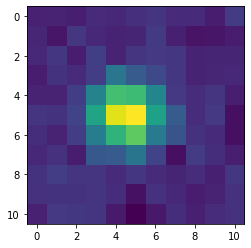

In [24]:
plt.imshow(noisy_sol[:,:,10])

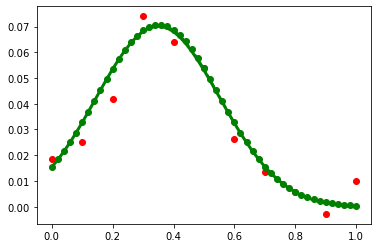

In [25]:
plt.plot(y_arr,noisy_sol[5,:,30], 'ro')
plt.plot(y_tot,data_tot[25,:,30], 'go--')
plt.plot(y_tot,sol[25,:,30],'g', label='t = 5',linewidth=3)

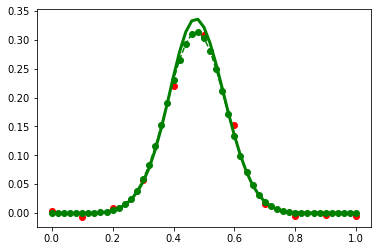

In [26]:
plt.plot(y_arr,noisy_sol[5,:,5], 'ro')
plt.plot(y_tot,data_tot[25,:,5], 'go--')
plt.plot(y_tot,sol[25,:,5],'g', label='t = 5',linewidth=3)

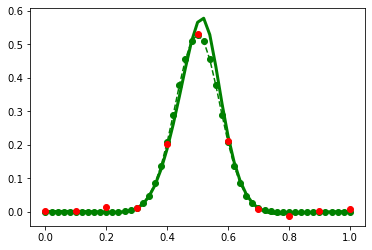

In [27]:
plt.plot(y_tot,data_tot[:,25,2], 'go--')
plt.plot(y_tot,sol[:,25,2],'g', label='t = 5',linewidth=3)
plt.plot(y_arr,noisy_sol[:,5,2], 'ro')

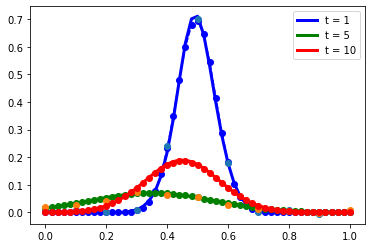

In [28]:


plt.plot(y_tot,data_tot[25,:,1], 'bo--')
plt.plot(y_tot,sol[25,:,1],'b', label='t = 1',linewidth=3)
plt.plot(y_arr,noisy_sol[5,:,1], 'o')

plt.plot(y_tot,data_tot[25,:,30], 'go--')
plt.plot(y_tot,sol[25,:,30],'g', label='t = 5',linewidth=3)
plt.plot(y_arr,noisy_sol[5,:,30], 'o')


plt.plot(y_tot,data_tot[25,:,10], 'ro--')
plt.plot(y_tot,sol[25,:,10],'r', label='t = 10',linewidth=3)
plt.legend()

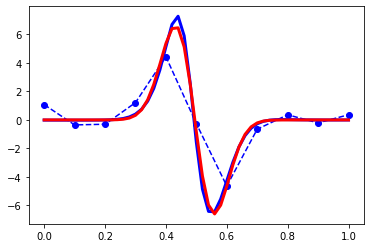

In [29]:
y = down_data[5,:,1]
x = y_arr
plt.plot(x,fd_spline(y,x), 'bo--')
plt.plot(x_tot,uy[25,:,1]*np.max(data_tot)/np.max(y_tot),'b', label='x = 1',linewidth=3)
plt.plot(x_tot,fd_spectral(data_tot[25,:,1],x_tot)*np.max(data_tot)/np.max(y_tot),'r', label='x = 1',linewidth=3)

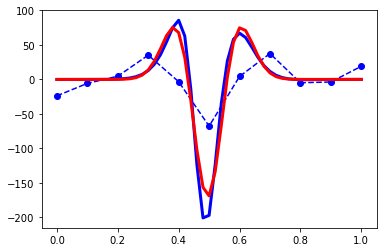

In [30]:
y = down_data[5,:,1]
x = y_arr
plt.plot(x,fd_spline(fd_spline(y,x),x), 'bo--')
plt.plot(x_tot,uyy[25,:,1]*np.max(data_tot)/np.max(y_tot),'b', label='x = 1',linewidth=3)
plt.plot(x_tot,fd_spectral(fd_spectral(data_tot[25,:,1],x_tot),x_tot),'r', label='x = 1',linewidth=3)

In [ ]:
y = down_data[5,:,1]
x = y_arr
plt.plot(x,fd_spline(y,x), 'bo--')
plt.plot(x_tot,uy[25,:,1]*np.max(data_tot)/np.max(y_tot),'b', label='x = 1',linewidth=3)

ValueError: x and y must have same first dimension, but have shapes (11,) and (51,)

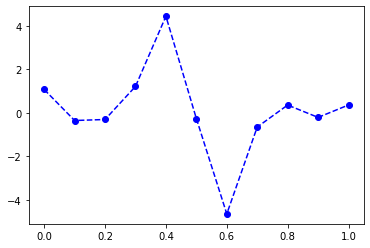

In [98]:
y = down_data[5,:,1]
x = y_arr
plt.plot(x,fd_spline(y,x), 'bo--')
plt.plot(x,uy[5,:,1]*np.max(tot_data)/np.max(y_tot),'b', label='x = 1',linewidth=3)
y = down_data[5,:,2]
x = y_arr
plt.plot(x,fd_spline(y,x), 'go--')
plt.plot(x,uy[5,:,2]*np.max(down_data)/np.max(y_grid),'g', label='x = 5',linewidth=3)
y = down_data[5,:,4]
x = y_arr
plt.plot(x,fd_spline(y,x), 'ro--')
plt.plot(x,uy[5,:,4]*np.max(down_data)/np.max(y_grid),'r', label='x = 10',linewidth=3)
plt.legend()

In [94]:
t = t_tot

In [97]:
down_data[5,2,:].shape

(41,)

In [91]:
y = down_data[5,2,:]
t = t_arr
plt.plot(t_tot,fd_sg(y_tot,t_tot), 'bo--')
plt.plot(t,ut[5,2,:]*np.max(down_data)/np.max(t_grid),'b', label='y = 12',linewidth=3)
y = down_data[5,5,:]
t = t_arr
plt.plot(t,fd_sg(y,t), 'go--')
plt.plot(t,ut[5,5,:]*np.max(down_data)/np.max(t_grid),'g', label='y = 6',linewidth=3)
y = down_data[5,8,:]
t = t_arr
plt.plot(t,fd_sg(y,t), 'ro--')
plt.plot(t,ut[5,8,:]*np.max(down_data)/np.max(t_grid),'r', label='y = 18',linewidth=3)
plt.legend()


ValueError: Length of t should match x.shape[0].

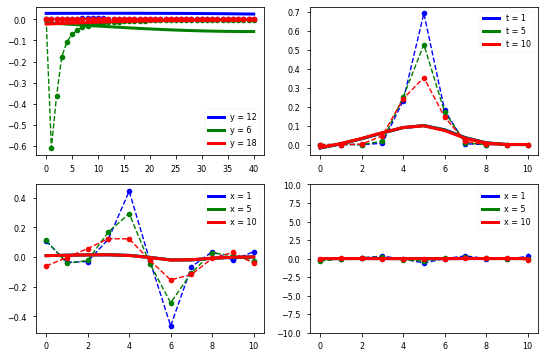

In [68]:
plt.style.use('seaborn-paper')
fig = plt.figure(figsize=(9,6))

plt.subplot(2,2, 1)

y = down_data[5,2,:]
t = t_arr
plt.plot(t,fd_sg(y,t), 'bo--')
plt.plot(t,ut[5,2,:],'b', label='y = 12',linewidth=3)
y = down_data[5,5,:]
t = t_arr
plt.plot(t,fd_sg(y,t), 'go--')
plt.plot(t,ut[5,5,:],'g', label='y = 6',linewidth=3)
y = down_data[5,8,:]
t = t_arr
plt.plot(t,fd_sg(y,t), 'ro--')
plt.plot(t,ut[5,8,:],'r', label='y = 18',linewidth=3)
plt.legend()

plt.subplot(2,2, 2)
y = down_data[5,:,1]
x = y_arr
plt.plot(x,y, 'bo--')
plt.plot(x,sol[5,:,1],'b', label='t = 1',linewidth=3)
y = down_data[5,:,2]
x = y_arr
plt.plot(x,y, 'go--')
plt.plot(x,sol[5,:,2],'g', label='t = 5',linewidth=3)
y = down_data[5,:,4]
x = y_arr
plt.plot(x,y, 'ro--')
plt.plot(x,sol[5,:,4],'r', label='t = 10',linewidth=3)
plt.legend()

plt.subplot(2,2, 3)

y = down_data[5,:,1]
x = y_arr
plt.plot(x,fd_spline(y,x), 'bo--')
plt.plot(x,uy[5,:,1]*np.max(down_data)/np.max(y_grid),'b', label='x = 1',linewidth=3)
y = down_data[5,:,2]
x = y_arr
plt.plot(x,fd_spline(y,x), 'go--')
plt.plot(x,uy[5,:,2]*np.max(down_data)/np.max(y_grid),'g', label='x = 5',linewidth=3)
y = down_data[5,:,4]
x = y_arr
plt.plot(x,fd_spline(y,x), 'ro--')
plt.plot(x,uy[5,:,4]*np.max(down_data)/np.max(y_grid),'r', label='x = 10',linewidth=3)
plt.legend()

plt.subplot(2,2,4)

y = down_data[5,:,1]
x = y_arr
plt.plot(x,fd_spline(fd_spline(y,x)), 'bo--')
plt.plot(x,uyy[5,:,1]*np.max(down_data)/(np.max(y_grid)*np.max(y_grid)),'b',label='x = 1',linewidth=3)
y = down_data[5,:,2]
x = y_arr
plt.plot(x,fd_spline(fd_spline(y,x)), 'go--')
plt.plot(x,uyy[5,:,2]*np.max(down_data)/(np.max(y_grid)*np.max(y_grid)),'g',label='x = 5',linewidth=3)
y = down_data[5,:,4]
x = y_arr
plt.plot(x,fd_spline(fd_spline(y,x)), 'ro--')
plt.plot(x,uyy[5,:,4]*np.max(down_data)/(np.max(y_grid)*np.max(y_grid)),'r',label='x = 10',linewidth=3)
plt.ylim(-10,10)
plt.legend()
#plt.savefig('derivatives.pdf')

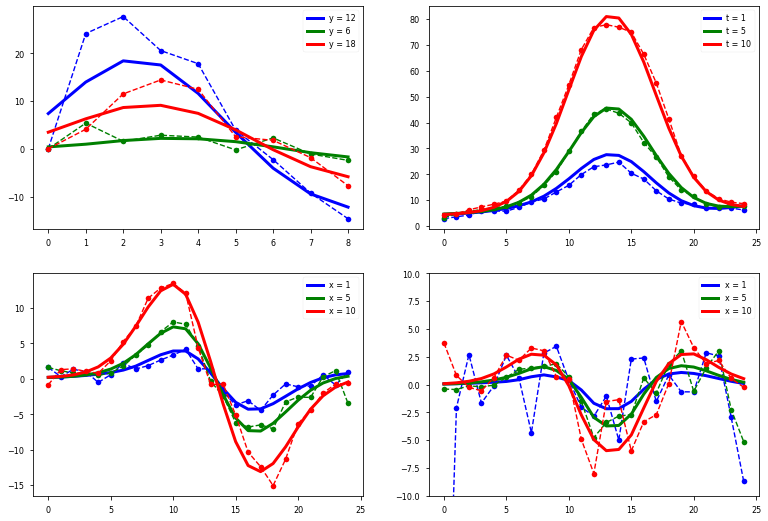

In [21]:
plt.style.use('seaborn-paper')
fig = plt.figure(figsize=(13,9))

plt.subplot(2,2, 1)

y = denoised_sol[10,12,:]
t = t_arr
plt.plot(t,fd_sg(y,t), 'bo--')
plt.plot(t,ut[10,12,:]*np.max(down_data)/np.max(t_grid),'b', label='y = 12',linewidth=3)
y = denoised_sol[10,6,:]
t = t_arr
plt.plot(t,fd_sg(y,t), 'go--')
plt.plot(t,ut[10,6,:]*np.max(down_data)/np.max(t_grid),'g', label='y = 6',linewidth=3)
y = denoised_sol[10,18,:]
t = t_arr
plt.plot(t,fd_sg(y,t), 'ro--')
plt.plot(t,ut[10,18,:]*np.max(down_data)/np.max(t_grid),'r', label='y = 18',linewidth=3)
plt.legend()

plt.subplot(2,2, 2)
y = denoised_sol[10,:,1]
x = y_arr
plt.plot(x,y, 'bo--')
plt.plot(x,sol[10,:,1]*np.max(down_data),'b', label='t = 1',linewidth=3)
y = denoised_sol[10,:,2]
x = y_arr
plt.plot(x,y, 'go--')
plt.plot(x,sol[10,:,2]*np.max(down_data),'g', label='t = 5',linewidth=3)
y = denoised_sol[10,:,4]
x = y_arr
plt.plot(x,y, 'ro--')
plt.plot(x,sol[10,:,4]*np.max(down_data),'r', label='t = 10',linewidth=3)
plt.legend()

plt.subplot(2,2, 3)

y = denoised_sol[10,:,1]
x = y_arr
plt.plot(x,fd_spline(y,x), 'bo--')
plt.plot(x,uy[10,:,1]*np.max(down_data)/np.max(y_grid),'b', label='x = 1',linewidth=3)
y = denoised_sol[10,:,2]
x = y_arr
plt.plot(x,fd_spline(y,x), 'go--')
plt.plot(x,uy[10,:,2]*np.max(down_data)/np.max(y_grid),'g', label='x = 5',linewidth=3)
y = denoised_sol[10,:,4]
x = y_arr
plt.plot(x,fd_spline(y,x), 'ro--')
plt.plot(x,uy[10,:,4]*np.max(down_data)/np.max(y_grid),'r', label='x = 10',linewidth=3)
plt.legend()

plt.subplot(2,2,4)

y = down_data[10,:,1]
x = y_arr
plt.plot(x,fd_spline(fd_spline(y,x)), 'bo--')
plt.plot(x,uyy[10,:,1]*np.max(down_data)/(np.max(y_grid)*np.max(y_grid)),'b',label='x = 1',linewidth=3)
y = denoised_sol[10,:,2]
x = y_arr
plt.plot(x,fd_spline(fd_spline(y,x)), 'go--')
plt.plot(x,uyy[10,:,2]*np.max(down_data)/(np.max(y_grid)*np.max(y_grid)),'g',label='x = 5',linewidth=3)
y = denoised_sol[10,:,4]
x = y_arr
plt.plot(x,fd_spline(fd_spline(y,x)), 'ro--')
plt.plot(x,uyy[10,:,4]*np.max(down_data)/(np.max(y_grid)*np.max(y_grid)),'r',label='x = 10',linewidth=3)
plt.ylim(-10,10)
plt.legend()
#plt.savefig('derivatives.pdf')